# Performance Evaluation

This is a simple, or naive, performance evaluation. Is just to get an idea of the performance of the StreamJsonParser class.</br>
And yes, no primary, or secondary, factors provided.

In [1]:
import json
import random
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from tqdm import tqdm

In [2]:
from IPython.display import display, Markdown, Image

In [3]:
# Add the src directory to the Python path
import sys
sys.path.append(str(Path.cwd().parent / 'src'))

In [4]:
# set LOG_LEVEL env variable to 50
import os
os.environ['LOG_LEVEL'] = '50'

In [5]:
from stack_stream_parser import StreamJsonParser

In [6]:
@dataclass
class ExperimentConfig:
    """Configuration for a performance experiment."""
    max_depth: int
    number_of_json_data: int
    number_of_runs: int = 10

@dataclass
class ExperimentResult:
    """Results from a performance experiment."""
    config: ExperimentConfig
    runtimes: List[float]
    mean_runtime: float
    std_runtime: float

## Data Generation
----------------
We generate a dataset of JSON strings based on the experiment configuration. Each JSON string is generated using the `generate_nested_json` function.
- Data is generated based on nested object fields.
- Data is generated based on primitive values.

In [7]:
def generate_nested_json(max_depth: int, current_depth: int = 0) -> Union[Dict, List, str, int, float, bool]:
    """Generate a nested JSON structure with controlled depth.
    
    Args:
        max_depth: Maximum nesting depth
        current_depth: Current depth in the recursion
    
    Returns:
        A JSON-serializable structure
    """
    if current_depth >= max_depth:
        # Leaf node - return a primitive value
        primitives = [
            "string value",
            123,
            3.14,
            True,
            False,
            None
        ]
        return random.choice(primitives)
    
    # Decide whether to create an object or array
    if random.random() < 0.5:
        # Create an object
        num_fields = random.randint(1, 3)
        return {
            f"field_{i}": generate_nested_json(max_depth, current_depth + 1)
            for i in range(num_fields)
        }
    else:
        # Create an array
        num_elements = random.randint(1, 3)
        return [
            generate_nested_json(max_depth, current_depth + 1)
            for _ in range(num_elements)
        ]

def generate_dataset(config: ExperimentConfig) -> List[str]:
    """Generate a dataset of JSON strings based on experiment configuration.
    
    Args:
        config: Experiment configuration
        
    Returns:
        List of JSON strings
    """
    return [
        json.dumps(generate_nested_json(config.max_depth))
        for _ in range(config.number_of_json_data)
    ]

## Experiments

In [8]:
def run_experiment(config: ExperimentConfig) -> ExperimentResult:
    """Run a single experiment with multiple runs.
    
    Args:
        config: Experiment configuration
        
    Returns:
        Experiment results including runtimes and statistics
    """
    dataset = generate_dataset(config)
    runtimes = []
    
    for _ in range(config.number_of_runs):
        start_time = time.perf_counter()
        
        # Process each JSON string
        for json_str in dataset:
            parser = StreamJsonParser()
            parser.consume(json_str)
                
        end_time = time.perf_counter()
        runtimes.append(end_time - start_time)
    
    return ExperimentResult(
        config=config,
        runtimes=runtimes,
        mean_runtime=np.mean(runtimes),
        std_runtime=np.std(runtimes)
    )

- Per experiment, we run for `number_of_runs` times, and we have a pre-defined seet of number of data points (10, 20 .... 100)
- We run the experiment for `number_of_runs` in order to calculate the mean and standard deviation.

In [9]:
def run_experiment_set(max_depth: int, number_of_runs: int = 10) -> List[ExperimentResult]:
    """Run a set of experiments with increasing data points.
    
    Args:
        max_depth: Maximum nesting depth for this set
        number_of_runs: Number of runs per experiment
        
    Returns:
        List of experiment results
    """
    results = [] 
    data_points = range(10, 110, 10)  # 10, 20, ..., 100
    
    for n_data in tqdm(data_points, desc=f"Running experiments for depth {max_depth}"):
        config = ExperimentConfig(
            max_depth=max_depth,
            number_of_json_data=n_data,
            number_of_runs=number_of_runs
        )
        results.append(run_experiment(config))
    
    return results

## Plot Results

In [10]:
def plot_results(all_results: List[List[ExperimentResult]]):
    """Plot experiment results.
    
    Args:
        all_results: List of results for each set of experiments
    """
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("husl", n_colors=len(all_results))
    
    for set_idx, set_results in enumerate(all_results):
        data_points = [r.config.number_of_json_data for r in set_results]
        means = [r.mean_runtime for r in set_results]
        stds = [r.std_runtime for r in set_results]
        
        plt.errorbar(
            data_points, 
            means, 
            yerr=stds,
            label=f'Depth {set_results[0].config.max_depth}',
            color=colors[set_idx],
            capsize=5,
            marker='o'
        )
    
    plt.xlabel('Number of JSON objects')
    plt.ylabel('Runtime (seconds)')
    plt.title('JsonFlow Performance Analysis')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig('performance_results.png')
    plt.close()

## Run Performance Test

In [11]:
"""Run all experiments and generate visualization."""
# Set random seed for reproducibility
random.seed(42)

# Run experiments for different depths
depths = [2, 4, 6, 8, 10]
all_results = []

for depth in depths:
    results = run_experiment_set(max_depth=depth)
    all_results.append(results)

# Plot results
plot_results(all_results)

# Display header
display(Markdown("## Performance Summary"))

# Create table header
table = "| Depth | Average Runtime (s) | Std Dev (s) | 95% CI Lower | 95% CI Upper |\n"
table += "|-------|-------------------|-------------|--------------|--------------|"

# Calculate and add rows
for set_results in all_results:
    depth = set_results[0].config.max_depth
    runtimes = [r.mean_runtime for r in set_results]
    
    mean_runtime = np.mean(runtimes)
    std_dev = np.std(runtimes)
    
    # Calculate 95% confidence interval
    confidence_level = 0.95
    degrees_of_freedom = len(runtimes) - 1
    t_value = stats.t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
    margin_of_error = t_value * (std_dev / np.sqrt(len(runtimes)))
    
    ci_lower = mean_runtime - margin_of_error
    ci_upper = mean_runtime + margin_of_error
    
    # Add row to table
    table += f"\n| {depth:2d} | {mean_runtime:.6f} | {std_dev:.6f} | {ci_lower:.6f} | {ci_upper:.6f} |"

# Display the table
display(Markdown(table))


Running experiments for depth 10: 100%|██████████| 10/10 [01:09<00:00,  6.99s/it]


## Performance Summary

| Depth | Average Runtime (s) | Std Dev (s) | 95% CI Lower | 95% CI Upper |
|-------|-------------------|-------------|--------------|--------------|
|  2 | 0.002380 | 0.001201 | 0.001520 | 0.003239 |
|  4 | 0.011639 | 0.006811 | 0.006767 | 0.016511 |
|  6 | 0.046409 | 0.023772 | 0.029404 | 0.063414 |
|  8 | 0.172185 | 0.087308 | 0.109729 | 0.234642 |
| 10 | 0.684551 | 0.350404 | 0.433887 | 0.935214 |

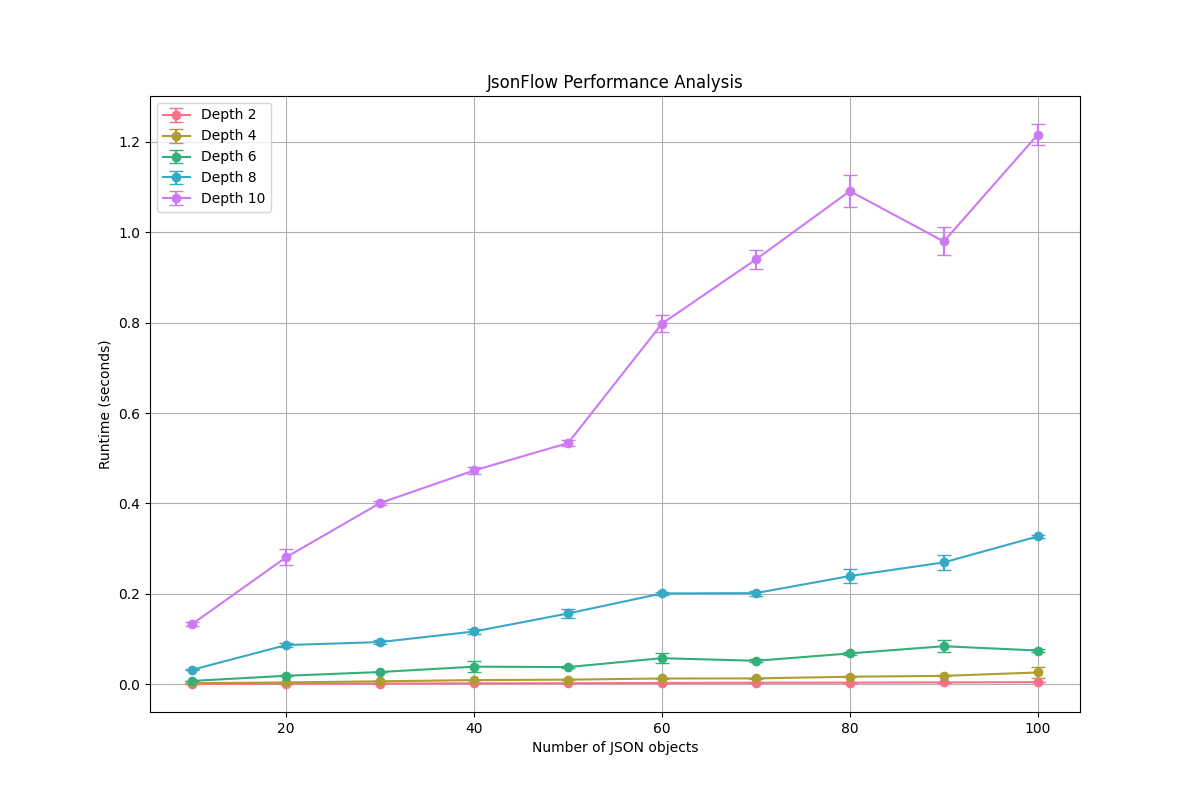

In [12]:
# display the plot
display(Image(filename='performance_results.png'))

## Conclusion
- The `StreamParser` class,`consume` does not scale linearly with the number of nested JSON objects.
- A possible solution  would be to remove the recursion, and transform it to an iterative algorithm.